churn analysis, save csv x,y
genre analysis, x,y 
demand, x,y

## Dataset Overview

In [6]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as plt
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

In [7]:
# Load data
df = pd.read_csv("dataset/dvd_rental_data.csv")

# Data Overview
print("datatype:", df.info())
print("\nShape:", df.shape)
print("\nUnique values per column:", df.nunique())
print("\nMissing values:", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14596 entries, 0 to 14595
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   inventory_id      14596 non-null  int64  
 1   film_id           14596 non-null  int64  
 2   title             14596 non-null  object 
 3   rental_duration   14596 non-null  int64  
 4   rental_rate       14596 non-null  float64
 5   length            14596 non-null  int64  
 6   replacement_cost  14596 non-null  float64
 7   rating            14596 non-null  object 
 8   category          14596 non-null  object 
 9   language          14596 non-null  object 
 10  store_id          14596 non-null  int64  
 11  rental_id         14596 non-null  int64  
 12  rental_date       14596 non-null  object 
 13  return_date       14413 non-null  object 
 14  payment_id        14596 non-null  int64  
 15  amount            14596 non-null  float64
 16  customer_id       14596 non-null  int64 

In [8]:
df.head()

,inventory_id,film_id,title,rental_duration,rental_rate,length,replacement_cost,rating,category,language,store_id,rental_id,rental_date,return_date,payment_id,amount,customer_id,first_name,last_name,active
0,3419,749,Rules Human,6,4.99,153,19.99,R,Horror,English,1,1520,15-06-2005 23:57,24-06-2005 23:46,17503,7.99,341,Peter,Menard,1
1,2512,552,Majestic Floats,5,0.99,130,15.99,PG,Documentary,English,2,1778,16-06-2005 18:54,22-06-2005 16:08,17504,1.99,341,Peter,Menard,1
2,2507,551,Maiden Home,3,4.99,138,9.99,PG,New,English,1,1849,17-06-2005 00:13,23-06-2005 18:37,17505,7.99,341,Peter,Menard,1
3,2047,445,Hyde Doctor,5,2.99,100,11.99,G,Classics,English,1,2829,19-06-2005 21:11,24-06-2005 18:10,17506,2.99,341,Peter,Menard,1
4,2569,563,Massacre Usual,6,4.99,165,16.99,R,Games,English,1,3130,20-06-2005 19:03,29-06-2005 18:05,17507,7.99,341,Peter,Menard,1


## Handling Missing Values

In [9]:
# Calculate missing percentage of return_date
missing_percentage = (df['return_date'].isnull().sum() / len(df)) * 100
print(f"Missing percentage for return_date: {missing_percentage:.2f}%")

# Dropping rows where return_date is missing
df.dropna(subset=['return_date'], inplace=True)

Missing percentage for return_date: 1.25%


## Feature Engineering

### Convert date columns to datetime

In [ ]:
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

# Extract month, day, and hour from rental_date

df['rental_month'] = df['rental_date'].dt.month
df['rental_day'] = df['rental_date'].dt.day
df['rental_hour'] = df['rental_date'].dt.hour

# Extract month, day, and hour from return_date

df['return_month'] = df['return_date'].dt.month
df['return_day'] = df['return_date'].dt.day
df['return_hour'] = df['return_date'].dt.hour

In [ ]:
# Calculate rental duration (in days)
df['rental_duration_days'] = (df['return_date'] - df['rental_date']).dt.days

In [ ]:
# # Concatenate first name and last name of the customer
# df['customer_name'] = df['first_name'] + ' ' + df['last_name']

# # Drop original first_name and last_name columns
# df.drop(['first_name', 'last_name'], axis=1, inplace=True)

In [13]:
# remove unnecessary columns

df.drop('language', axis=1, inplace=True)
df.drop(['inventory_id','film_id','store_id','rental_id','customer_id','payment_id'], axis=1, inplace=True)

In [14]:
# Final data overview
print("Column_Name", df.columns)
print("Shape:", df.shape)
print("\nUnique values:", df.nunique())

Shape: (14413, 17)

Unique values: title                   958
rental_duration           5
rental_rate               3
length                  140
replacement_cost         21
rating                    5
category                 16
amount                   12
active                    2
rental_month              3
rental_day               26
rental_hour              24
return_month              4
return_day               31
return_hour              24
rental_duration_days     10
customer_name           599
dtype: int64


In [15]:
df.head()

,title,rental_duration,rental_rate,length,replacement_cost,rating,category,amount,active,rental_month,rental_day,rental_hour,return_month,return_day,return_hour,rental_duration_days,customer_name
0,Rules Human,6,4.99,153,19.99,R,Horror,7.99,1,6,15,23,6,24,23,8,Peter Menard
1,Majestic Floats,5,0.99,130,15.99,PG,Documentary,1.99,1,6,16,18,6,22,16,5,Peter Menard
2,Maiden Home,3,4.99,138,9.99,PG,New,7.99,1,6,17,0,6,23,18,6,Peter Menard
3,Hyde Doctor,5,2.99,100,11.99,G,Classics,2.99,1,6,19,21,6,24,18,4,Peter Menard
4,Massacre Usual,6,4.99,165,16.99,R,Games,7.99,1,6,20,19,6,29,18,8,Peter Menard


In [16]:
df.to_csv('processed_data/preprocessing_data.csv')

### EDA (Time-series Analysis)

In [ ]:
# Monthly rentals
plt.figure(figsize=(10, 6))
sns.countplot(x='rental_month', data=df)
plt.title('Monthly Rental Distribution')
plt.xlabel('Month of the year')
plt.ylabel('Number of Rentals')
plt.show()

# Day-wise rentals
plt.figure(figsize=(10, 6))
sns.countplot(x='rental_day', data=df)
plt.title('Day-wise Rental Distribution')
plt.xlabel('Day of the month')
plt.ylabel('Number of Rentals')
plt.show()

# Hourly rentals
plt.figure(figsize=(10, 6))
sns.countplot(x='rental_hour', data=df)
plt.title('Hourly Rental Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rentals')
plt.show()

# Rental Duration by Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rental_duration_days', y='amount', data=df)
plt.title('Rental Duration by Amount Paid')
plt.xlabel('Rental Duration (Days)')
plt.ylabel('Amount Paid (dollars)')
plt.show()

# Distribution of rental amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], bins=30, kde=True)
plt.title('Distribution of Rental Amounts')
plt.xlabel('Amount Paid (dollars)')
plt.ylabel('Frequency')
plt.show()

## Feature Selection

In [15]:
# Check data types of each column
print(df.dtypes)

title                    object
rental_duration           int64
rental_rate             float64
length                    int64
replacement_cost        float64
rating                   object
category                 object
amount                  float64
active                    int64
rental_month              int32
rental_day                int32
rental_hour               int32
return_month              int32
return_day                int32
return_hour               int32
rental_duration_days      int64
customer_name            object
dtype: object


In [16]:
# Identify continuous (numeric) columns
continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns
print("Continuous Columns:", continuous_columns)

# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:", categorical_columns)

Continuous Columns: Index(['rental_duration', 'rental_rate', 'length', 'replacement_cost',
       'amount', 'active', 'rental_duration_days'],
      dtype='object')

Categorical Columns: Index(['title', 'rating', 'category', 'customer_name'], dtype='object')


In [17]:
categorical_columns = ['rating', 'category']
continuous_columns = ['rental_rate', 'replacement_cost']

In [18]:
df['rating'].value_counts()

rating
PG-13    3203
NC-17    2964
PG       2903
R        2868
G        2475
Name: count, dtype: int64

In [19]:
df['rating'] = df['rating'].map({"PG-13":0,'NC-17':1,'PG':2,'R':3,"G":4})
df['rating'].value_counts()

rating
0    3203
1    2964
2    2903
3    2868
4    2475
Name: count, dtype: int64

In [20]:
print(df['category'].value_counts().sort_index())

category
Action          996
Animation      1044
Children        855
Classics        851
Comedy          842
Documentary     930
Drama           946
Family          975
Foreign         942
Games           870
Horror          761
Music           739
New             851
Sci-Fi          990
Sports         1066
Travel          755
Name: count, dtype: int64


In [21]:
df['category'].unique()

array(['Horror', 'Documentary', 'New', 'Classics', 'Games', 'Sci-Fi',
       'Foreign', 'Family', 'Travel', 'Music', 'Sports', 'Comedy',
       'Drama', 'Action', 'Children', 'Animation'], dtype=object)

In [22]:
df['category'] = df['category'].map({'Horror':0, 'Documentary':1, 'New':2, 'Classics':3, 'Games':4, 'Sci-Fi':5,
       'Foreign':6, 'Family':7, 'Travel':8, 'Music':9, 'Sports':10, 'Comedy':11,
       'Drama':12, 'Action':13, 'Children':14, 'Animation':15})
df['category'].value_counts()

category
10    1066
15    1044
13     996
5      990
7      975
12     946
6      942
1      930
4      870
14     855
2      851
3      851
11     842
0      761
8      755
9      739
Name: count, dtype: int64

Non-numeric columns: Index(['title', 'customer_name'], dtype='object')


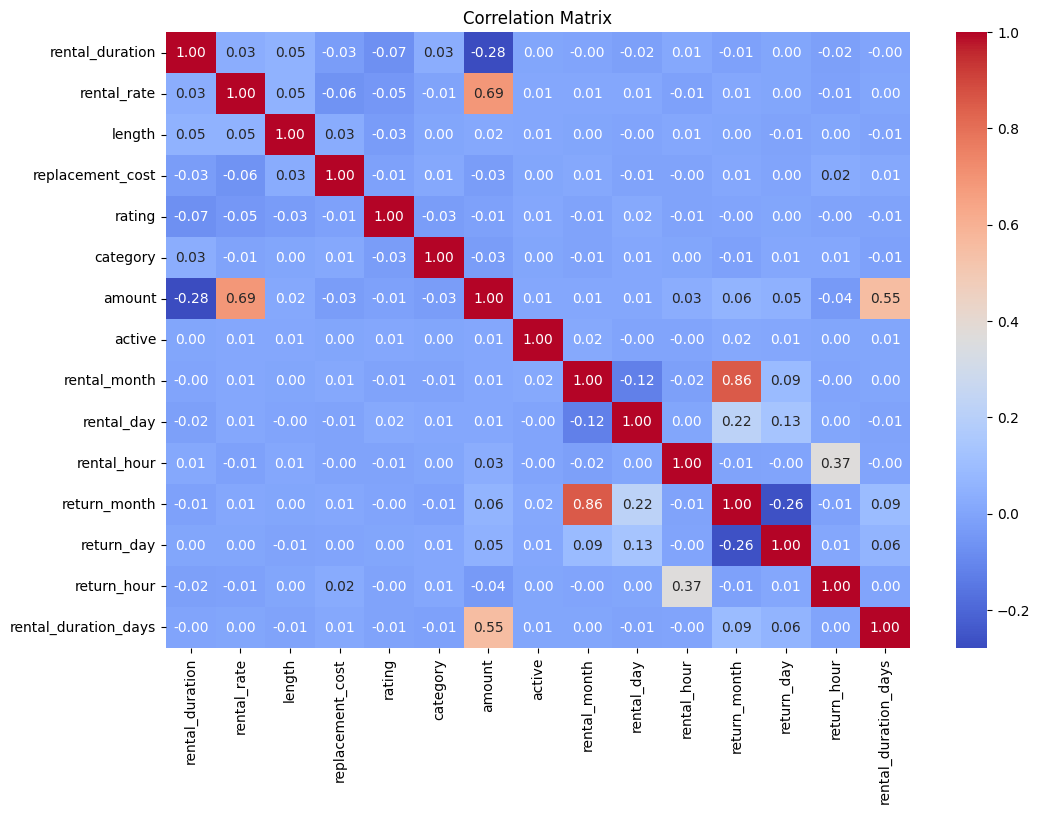

In [23]:
# Check for non-numeric columns
non_numeric_columns = df.select_dtypes(exclude='number').columns
print("Non-numeric columns:", non_numeric_columns)

# If necessary, drop non-numeric columns or convert them into numerical values
df.drop(non_numeric_columns, axis=1, inplace=True)

# Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [24]:
from sklearn.preprocessing import LabelEncoder
import pickle

# encoding numerical columns
le_cont = {}
for col in continuous_columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    le_cont[col] = encoder

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(le_cont, f)

In [25]:
le_cont

{'rental_rate': LabelEncoder(), 'replacement_cost': LabelEncoder()}

In [26]:
df.head()

,rental_duration,rental_rate,length,replacement_cost,rating,category,amount,active,rental_month,rental_day,rental_hour,return_month,return_day,return_hour,rental_duration_days
0,6,2,153,10,3,0,7.99,1,6,15,23,6,24,23,8
1,5,0,130,6,2,1,1.99,1,6,16,18,6,22,16,5
2,3,2,138,0,2,2,7.99,1,6,17,0,6,23,18,6
3,5,1,100,2,4,3,2.99,1,6,19,21,6,24,18,4
4,6,2,165,7,3,4,7.99,1,6,20,19,6,29,18,8


In [27]:
# Separate features and target

x = df.drop('amount', axis=1)
y = df['amount']

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train

,rental_duration,rental_rate,length,replacement_cost,rating,category,active,rental_month,rental_day,rental_hour,return_month,return_day,return_hour,rental_duration_days
696,5,2,110,16,0,3,1,6,18,19,6,27,16,8
9824,5,2,58,3,3,11,1,7,28,4,7,30,2,1
2138,7,2,161,13,3,6,1,8,21,22,8,23,23,2
13734,4,0,79,11,0,8,1,7,12,16,7,20,18,8
6480,5,2,84,0,3,2,1,8,21,13,8,23,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10695,4,2,84,11,3,5,1,7,31,1,8,4,4,4
1060,5,1,102,1,3,14,1,6,17,19,6,25,0,7
9735,3,1,80,17,4,6,1,7,31,20,8,6,23,6
4606,4,2,151,19,0,12,1,8,18,9,8,21,12,3


In [29]:
scaler = StandardScaler()

In [30]:
scaler.fit(x_train)

StandardScaler()

In [31]:
x_train_scaler = scaler.transform(x_train)
x_test_scaler = scaler.transform(x_test)

In [32]:
x_train_scaler_df = pd.DataFrame(x_train_scaler,columns = x_train.columns)
x_test_scaler_df = pd.DataFrame(x_test_scaler,columns = x_test.columns)

In [33]:
x_test_scaler_df

,rental_duration,rental_rate,length,replacement_cost,rating,category,active,rental_month,rental_day,rental_hour,return_month,return_day,return_hour,rental_duration_days
0,-0.677693,0.036524,-0.670844,-1.679631,0.786888,-0.370635,0.159756,-0.373979,-1.184324,1.095384,-0.597667,-0.966729,1.659016,-1.334705
1,1.465009,0.036524,-0.770556,0.618653,-0.638770,-1.022084,0.159756,1.089576,0.529990,0.229665,0.773922,1.564025,0.514717,1.708288
2,-1.391927,0.036524,1.597610,-0.530489,0.786888,-1.456383,0.159756,1.089576,0.187128,1.383957,0.773922,0.463697,0.800792,-1.334705
3,-0.677693,1.251261,-1.443613,1.275306,0.074059,-0.804934,0.159756,1.089576,0.301415,0.662525,0.773922,1.343960,0.800792,1.708288
4,-0.677693,0.036524,0.027142,0.290327,0.074059,0.497963,0.159756,-1.837534,-0.155735,0.518238,-1.969256,0.243632,0.228643,-0.954331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,-1.391927,1.251261,0.550631,0.618653,-0.638770,0.932263,0.159756,-0.373979,1.330004,-0.347481,-0.597667,1.564025,-0.200469,-0.954331
3600,-0.677693,-1.178213,0.201638,-1.187142,-1.351598,-1.673532,0.159756,-0.373979,-1.184324,-0.780340,-0.597667,-0.636631,-1.630843,-0.573957
3601,0.036541,1.251261,-0.321851,0.290327,-1.351598,1.583711,0.159756,-0.373979,-1.070036,-1.213200,-0.597667,-0.086467,-0.915656,1.327914
3602,0.036541,-1.178213,0.101926,-0.366326,-0.638770,-0.153485,0.159756,1.089576,0.529990,-0.636054,0.773922,1.343960,-1.344768,0.567165


In [34]:
x_train_scaler_df.shape[1]

14

In [35]:
y_train.shape

(10809,)

In [36]:
# Initialize the model
model = Sequential()

# Input layer
model.add(Dense(512, input_dim=x_train.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(256, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError(), MeanAbsoluteError()])
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
result = model.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(x_test, y_test)
print(f'Test Loss (MSE): {test_loss}')

# Predictions and R² score
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

# Convert history to DataFrame for analysis
result_df = pd.DataFrame(result.history)
print(result_df)

c:\IT\github\ds_dvd_rental_analysis\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,217 (707.88 KB)

 Trainable params: 181,217 (707.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.5181 - mean_absolute_error: 1.8843 - mean_squared_error: 6.5181 - val_loss: 0.6629 - val_mean_absolute_error: 0.6687 - val_mean_squared_error: 0.6629
Epoch 2/80
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8129 - mean_absolute_error: 0.7267 - mean_squared_error: 0.8129 - val_loss: 0.5149 - val_mean_absolute_error: 0.5809 - val_mean_squared_error: 0.5149
Epoch 3/80
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4413 - mean_absolute_error: 0.5259 - mean_squared_error: 0.4413 - val_loss: 0.0941 - val_mean_absolute_error: 0.2399 - val_mean_squared_error: 0.0941
Epoch 4/80
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1146 - mean_absolute_error: 0.2580 - mean_squared_error: 0.1146 - val_loss: 0.1176 - val_mean_absolute_error: 0.2475 - val_mean_squared_error: 0.1176
Epoch 5/80
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1631 - mean_absolute_error: 0.3036 - mean_squared_error: 0.1631 - val_loss: 0.1091 - val_m

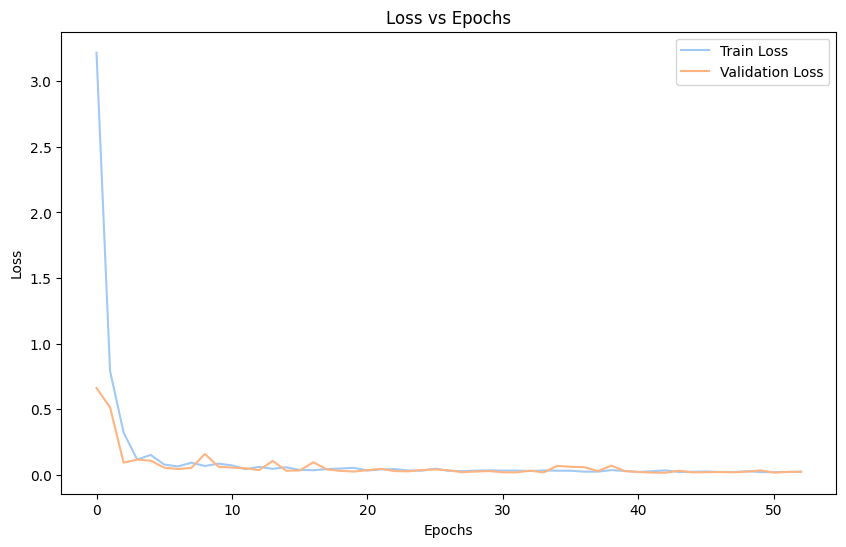

In [37]:
# Plotting training history

plt.figure(figsize=(10, 6))
plt.plot(result_df['loss'], label='Train Loss')
plt.plot(result_df['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

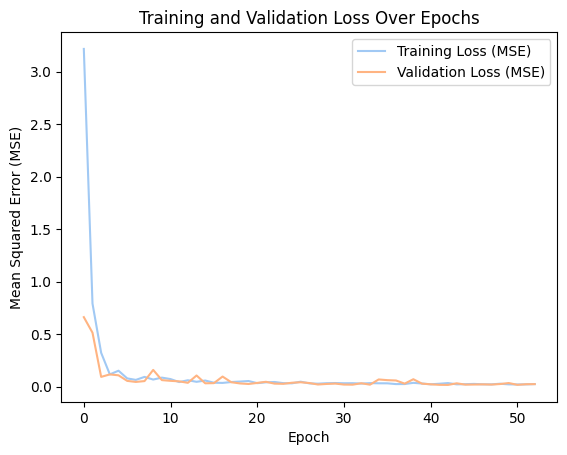

In [38]:
# Plot the training and validation loss

plt.plot(result.history['loss'], label='Training Loss (MSE)')
plt.plot(result.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


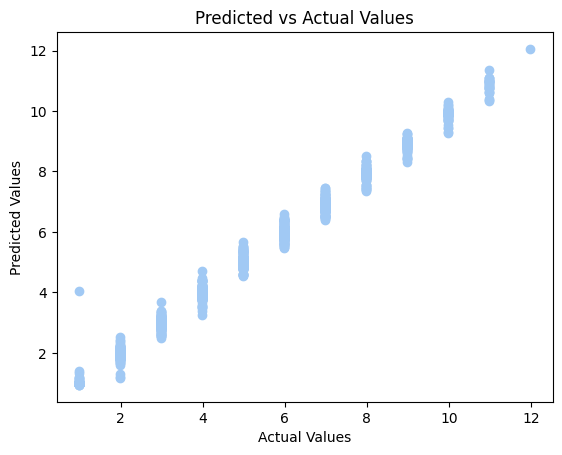

In [39]:
# Get predictions for the test set
y_pred = model.predict(x_test)

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [40]:
# Get predictions for the test set
y_pred = model.predict(x_test)

# If y_test is a pandas Series, convert it to a NumPy array
if isinstance(y_test, pd.Series):
    y_test = y_test.values

# Flatten y_pred if it's a 2D array
y_pred = y_pred.flatten()

# Calculate residuals (errors)
residuals = y_test - y_pred

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


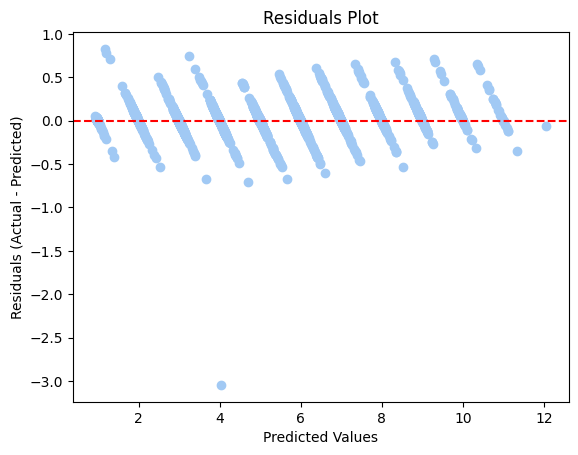

In [41]:
# Plot residuals
plt.scatter(y_pred, residuals)
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [42]:
model.save("dl_model.h5")

In [43]:
from keras.utils import to_categorical
from keras.models import load_model

new_model = load_model("dl_model.h5")

In [44]:
first_row = x_test.iloc[0].to_numpy()
print(first_row)

[ 4  1 88  0  3  6  1  7  7 19  7  8 23  1]


In [45]:
new_model.predict(np.array([first_row]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[2.9933386]], dtype=float32)

In [46]:
x_test['rental_month'].value_counts()

rental_month
7    1656
8    1428
6     520
Name: count, dtype: int64

In [47]:
df['length'].min()
df['length'].max()

185

In [48]:
x_test.columns

Index(['rental_duration', 'rental_rate', 'length', 'replacement_cost',
       'rating', 'category', 'active', 'rental_month', 'rental_day',
       'rental_hour', 'return_month', 'return_day', 'return_hour',
       'rental_duration_days'],
      dtype='object')

In [49]:
le_cont

{'rental_rate': LabelEncoder(), 'replacement_cost': LabelEncoder()}

In [50]:
le_cont['replacement_cost'].classes_

array([ 9.99, 10.99, 11.99, 12.99, 13.99, 14.99, 15.99, 16.99, 17.99,
       18.99, 19.99, 20.99, 21.99, 22.99, 23.99, 24.99, 25.99, 26.99,
       27.99, 28.99, 29.99])

In [51]:
array = ['Horror', 'Documentary', 'New', 'Classics', 'Games', 'Sci-Fi',
            'Foreign', 'Family', 'Travel', 'Music', 'Sports', 'Comedy',
            'Drama', 'Action', 'Children', 'Animation']

category = 'Classics'       
num = array.index(category)
print(float(num))

3.0
